##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Actor-Critic 방법으로 CartPole의 문제 풀기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 TensorFlow로 [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) 방법을 구현하여 [Open AI Gym](https://gym.openai.com/) CartPole-V0 환경에서 에이전트를 훈련하는 방법을 보여줍니다. 독자가 강화 학습의 [정책 그래디언드 방법](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)에 어느 정도 익숙하다고 가정합니다.


**Actor-Critic 방법**

Actor-Critic 방법은 가치 함수와 독립적인 정책 함수를 나타내는 [Temporal Difference(TD) 학습](https://en.wikipedia.org/wiki/Temporal_difference_learning) 방법입니다.

정책 함수(또는 정책)는 에이전트가 주어진 상태에 따라 취할 수 있는 동작에 대한 확률 분포를 반환합니다. 가치 함수는 주어진 상태에서 시작하여 특정 정책에 따라 영원히 동작하는 에이전트의 예상 이익을 결정합니다.

Actor-Critic 방법에서 정책은 주어진 상태에 따라 가능한 일련의 동작을 제안하는 *행위자*라고 하며, 추정값 함수는 주어진 정책에 따라 *행위자*가 취한 동작을 평가하는 *비평가*라고 합니다.

이 튜토리얼에서 *행위자*와 *비평가* 모두 두 개의 출력이 있는 하나의 신경망을 사용하여 표현됩니다.


**CartPole-v0**

[CartPole-v0 환경](https://gym.openai.com/envs/CartPole-v0)에서는 마찰이 없는 트랙을 따라 이동하는 카트에 막대가 연결되어 있습니다. 막대는 똑바른 상태에서 시작되고 에이전트의 목표는 카트에 -1 또는 +1의 힘을 가하여 카트가 넘어지는 것을 방지하는 것입니다. 막대가 똑바로 유지될 때마다 +1의 보상이 주어집니다. 에피소드는 (1) 막대가 수직에서 15도 이상 기울어지거나 (2) 카트가 중앙에서 2.4 단위 이상 이동하면 끝납니다.

<center>
  <pre data-md-type="custom_pre">&lt;figure&gt;
    &lt;image src="images/cartpole-v0.gif"&gt;
    &lt;figcaption&gt;Cartpole-v0 환경에서 훈련된 Actor-Critic 모델&lt;/figcaption&gt;
  &lt;/image&gt;&lt;/figure&gt;</pre>
</center>


이 문제는 에피소드에 대한 평균 총 보상이 100회 연속 시도에서 195에 도달하면 "해결"된 것으로 간주됩니다.

## 설정

필요한 패키지를 가져오고 전역 설정을 구성합니다.


In [2]:
!pip install gym

In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import gym
import numpy as np
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

## 모델

*행위자*와 *비평가*는 각각 동작 확률과 비평 값을 생성하는 하나의 신경망을 사용하여 모델링됩니다. 이 튜토리얼에서는 모델 하위 클래스화를 사용하여 모델을 정의합니다.

순방향 전달 중에 모델은 상태를 입력으로 받고 상태 종속 [값 함수](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions)를 모델링하는 동작 확률과 비평 값 $V$를 모두 출력합니다. 목표는 예상 [이익](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return)을 최대화하는 $\pi$ 정책을 기반으로 행동을 선택하는 모델을 훈련하는 것입니다.

Cartpole-v0의 경우, 상태를 나타내는 네 가지 값이 있는데, 각각 카트 위치, 카트 속도, 막대 각도 및 막대 속도입니다. 에이전트는 카트를 각각 왼쪽(0)과 오른쪽(1)으로 밀기 위해 두 가지 동작을 취할 수 있습니다.

자세한 내용은 [OpenAI Gym의 CartPole-v0 위키 페이지](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)를 참조하세요.


In [5]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## 훈련

에이전트를 훈련하기 위해 다음 단계를 따릅니다.

1. 환경에서 에이전트를 실행하여 에피소드별로 훈련 데이터를 수집합니다.
2. 각 시간 스텝에서 예상 이익을 계산합니다.
3. 결합된 Actor-Critic 모델의 손실을 계산합니다.
4. 그래디언트를 계산하고 네트워크 매개변수를 업데이트합니다.
5. 성공 기준 또는 최대 에피소드에 도달할 때까지 1~4를 반복합니다.


### 1. 훈련 데이터 수집하기

지도 학습에서와 같이 Actor-Critic 모델을 훈련하려면 훈련 데이터가 필요합니다. 그러나, 이러한 데이터를 수집하려면 모델이 환경에서 "실행"되어야 합니다.

여기서는 각 에피소드에 대한 훈련 데이터를 수집합니다. 그런 다음, 모델의 가중치에 의해 매개변수화된 현재 정책을 기반으로 동작 확률과 비평 값을 생성하기 위해 각 타임스텝에서 모델의 순방향 전달을 환경 상태에서 실행합니다.

다음 동작은 모델에 의해 생성된 동작 확률로부터 샘플링되며, 그런 다음 환경에 적용되어 다음 상태와 보상을 생성합니다.

이 프로세스는 더 빠른 훈련을 위해 나중에 TensorFlow 그래프로 컴파일할 수 있도록 TensorFlow 연산을 사용하는 `run_episode` 함수에서 구현됩니다. `tf.TensorArray`는 가변 길이 배열에서 Tensor 반복을 지원하는 데 사용되었습니다.

In [7]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. 예상 이익 계산하기

한 에피소드 동안 수집된 각 타임스텝 $t$, ${r_{t}}^{T}*{t=1}$에서 보상의 시퀀스를 예상 이익 ${G*{t}}^{T}_{t=1}$의 시퀀스로 변환합니다. 여기서 보상의 합계는 현재 타임스텝 $t$에서 $T$까지 계산되며, 각 보상에 기하급수적으로 감소하는 할인 계수 $\gamma$를 곱합니다.

$$G_{t} = \sum^{T}{t'=t} \gamma^{t'-t}r{t'}$$

$\gamma\in(0,1)$ 이후, 현재 타임스텝에서 더 멀리 떨어진 보상에는 더 적은 가중치가 부여됩니다.

직관적으로, 예상 이익은 단순히 지금 보상이 이후 보상보다 낫다는 것을 암시합니다. 이것은 수학적 의미에서 보상의 합이 수렴하도록 하려는 것입니다.

또한, 훈련을 안정화하기 위해 이익의 결과 시퀀스를 표준화합니다(즉, 평균이 0이고 단위 표준 편차를 갖도록 함).


In [9]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic 손실

여기서는 하이브리드 Actor-Critic 모델을 사용하고 있기 때문에 아래와 같이 훈련을 위해 행위자와 비평가 손실의 조합인 손실 함수를 사용합니다.

$$L = L_{actor} + L_{critic}$$

#### Actor 손실

[비평가가 상태 종속 기준선인 정책 그래디언트](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s)를 기반으로 행위자 손실을 공식화하고 단일 샘플(에피소드별) 추정치를 계산합니다.

$$L_{actor} = -\sum^{T}*{t=1} log\pi*{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}*{\theta}(s*{t})]$$

여기서:

- $T$: 에피소드별로 달라질 수 있는 에피소드별 타임스텝의 수
- $s_{t}$: $t$ 타임스텝의 상태
- $a_{t}$: $s$ 상태에 따라 $t$ 타임스텝에서 선택된 동작
- $\pi_{\theta}$: $\theta$에 의해 매개변수화된 정책(행위자)
- $V^{\pi}_{\theta}$: 마찬가지로 $\theta$에 의해 매개변수화된 값 함수(비평가)
- $G = G_{t}$: 주어진 상태에 대한 예상 이익, 타임스텝 $t$에서 동작 쌍

결합된 손실을 최소화하여 보상이 더 높은 행동의 확률을 최대화하려고 하므로 합계에 음의 항을 추가합니다.

<br>

##### 이점

$L_{actor}$ 공식에서 $G - V$ 항을 [이점](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions)이라고 하며, 이는 특정한 상태에서 $\pi$ 정책에 따라 선택된 임의의 동작보다 이 상태에 얼마나 더 나은 동작이 주어지는지를 나타냅니다.

기준선을 제외할 수 있지만 이로 인해 훈련 중에 큰 변동이 발생할 수 있습니다. 그리고 비평가 $V$를 기준선으로 선택할 때의 좋은 점은 가능한 한 $G$에 가깝게 훈련되어 변동이 낮아진다는 것입니다.

또한, 비평가가 없으면 알고리즘이 예상 이익을 바탕으로 특정 상태에서 취하는 행동의 확률을 높이려고 시도할 것이며, 이 때 동작 사이의 상대적 확률이 같게 유지된다면 큰 차이가 생기지 않습니다.

예를 들어, 주어진 상태에서 두 행동의 예상 이익이 같다고 가정합니다. 비평가가 없으면 알고리즘은 목표 $J$에 따라 이들 동작의 확률을 높이려고 합니다. 비평가의 경우, 이점($G - V = 0$)이 없기 때문에 동작의 확률을 높이는 데 따른 이점이 없으며 알고리즘이 그래디언트를 0으로 설정합니다.

<br>

#### 비평가 손실

$V$를 $G$에 최대한 가깝게 훈련하는 것은 다음 손실 함수를 사용한 회귀 문제로 설정할 수 있습니다.

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

여기서 $L_{\delta}$는 [Huber 손실](https://en.wikipedia.org/wiki/Huber_loss)로, 제곱 오차 손실보다 데이터의 이상 값에 덜 민감합니다.


In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. 매개변수를 업데이트하기 위한 훈련 단계 정의하기

위의 모든 단계를 모든 에피소드에서 실행되는 훈련 단계로 결합합니다. 손실 함수로 이어지는 모든 단계는 `tf.GradientTape` 컨텍스트로 실행되어 자동 미분이 가능합니다.

이 튜토리얼에서는 Adam 옵티마이저를 사용하여 모델 매개변수에 그래디언트를 적용합니다.

할인되지 않은 보상의 합계인 `episode_reward`도 이 단계에서 계산됩니다. 이 값은 나중에 성공 기준이 충족되는지 평가하는 데 사용됩니다.

`tf.function` 컨텍스트를 `train_step` 함수에 적용하여 호출 가능한 TensorFlow 그래프로 컴파일할 수 있고, 그러면 훈련 속도가 10배 빨라질 수 있습니다.


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. 훈련 루프 실행하기

성공 기준 또는 최대 에피소드 수에 도달할 때까지 훈련 단계를 실행하는 방식으로 훈련을 실행합니다.

대기열을 사용하여 에피소드 보상의 실행 레코드를 유지합니다. 100회 시도에 도달하면 가장 오래된 보상이 대기열의 왼쪽(꼬리쪽) 끝에서 제거되고 최근 보상이 머리쪽(오른쪽)에 추가됩니다. 계산 효율을 높이기 위해 보상의 누적 합계도 유지됩니다.

런타임에 따라 훈련은 1분 이내에 완료될 수 있습니다.

In [12]:
#from statistics import *

In [15]:
from statistics import mean, median, mode, stdev

In [16]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    # running_reward = statistics.mean(episodes_reward)
    running_reward = mean(episodes_reward)
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 541:   5%|▌         | 541/10000 [03:49<1:06:48,  2.36it/s, episode_reward=200, running_reward=195]


Solved at episode 541: average reward: 195.13!
CPU times: user 5min 24s, sys: 50.2 s, total: 6min 14s
Wall time: 3min 49s


## 시각화

훈련 후에는 모델이 환경에서 어떻게 동작하는지 시각화하는 것이 좋습니다. 아래 셀을 실행하여 모델의 한 에피소드 실행에 대한 GIF 애니메이션을 생성할 수 있습니다. Colab에서 환경의 이미지를 올바르게 렌더링하려면 OpenAI Gym에 대한 추가 패키지를 설치해야 합니다.

In [17]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


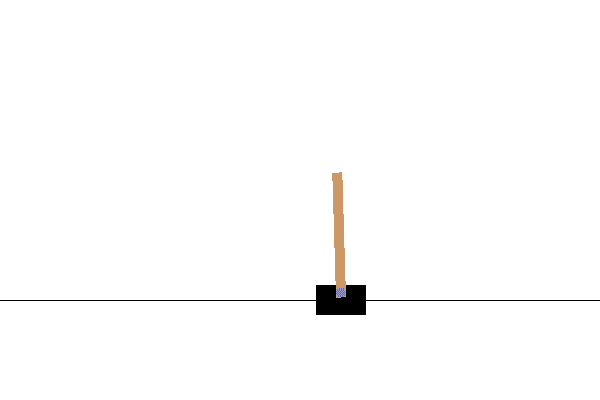

In [18]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## 다음 단계

이 튜토리얼에서는 Tensorflow를 사용하여 Actor-Critic 방법을 구현하는 방법을 보여주었습니다.

다음 단계로 OpenAI Gym의 다른 환경에서 모델의 훈련을 시도할 수 있습니다.

Actor-Critic 방법 및 Cartpole-v0 문제에 대한 추가 정보는 다음 리소스를 참조하세요.

- [Actor Critic 방법](https://hal.inria.fr/hal-00840470/document)
- [CAL(Actor Critic Lecture)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [카트폴 학습 제어 문제 [Barto 등 1983]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)

TensorFlow에서 더 많은 강화 학습 예를 보려면 다음 리소스를 확인하세요.

- [강화 학습 코드 예제(keras.io)](https://keras.io/examples/rl/)
- [TF-Agents 강화 학습 라이브러리](https://www.tensorflow.org/agents)
